In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download('punkt')
nltk.download('stopwords')
words = stopwords.words("english")
stemmer = SnowballStemmer('english')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
stopwords_set = set(stopwords.words("english"))
df = pd.read_csv('1429_1.csv', keep_default_na=False, skip_blank_lines=False)
df = df.replace(np.nan, '', regex=True)

C:\Users\pishi\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df['newComments'] = df[['reviews.text', 'reviews.title']].apply(lambda x: ' '.join(x), axis=1)
df['newComments'] = df['reviews.text'].apply(lambda x: " ".join([stemmer.stem(i) for i in re.sub("[^a-zA-Z]", " ", x).split() if i not in stopwords_set]).lower())
TVec = TfidfVectorizer(sublinear_tf=True, min_df=6, stop_words='english')
ch2 = SelectPercentile(chi2, percentile=9.5)
X_text_processing = TVec.fit_transform(df['newComments'])

#df['reviews.rating'].astype(str).astype(int).astype(float)
#df['reviews.rating'].convert_objects(convert_numeric=True)
df['reviews.rating'] = pd.to_numeric(df['reviews.rating'],errors='coerce')

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(df[['reviews.rating']])
df['reviews.rating']=imp.transform(df[['reviews.rating']]).ravel()
'''
imputed_DF = pd.DataFrame(imp.fit_transform(df.loc[:, 14]))
imputed_DF.columns = df.columns
imputed_DF.index = df.index
'''
y_text_processing = df['reviews.rating'].astype(np.int64)

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
from numpy import array
vect = CountVectorizer(binary=True, stop_words=stopwords.words('english'), lowercase=True, min_df=6,  max_features=5000)
label_encoder_y = LabelEncoder()
y_recommended = df['reviews.doRecommend']


#df['reviews.doRecommend'].eq('TRUE').mul(1)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 1 if x == "TRUE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == "FALSE" else x)
df['reviews.doRecommend'] = df['reviews.doRecommend'].replace(np.nan, '', regex=True)
df['reviews.doRecommend'] = df['reviews.doRecommend'].apply(lambda x: 0 if x == '' else x)

#print(onehot_encoded)
y_keras = df['reviews.doRecommend']


X_train, X_test, y_train, y_test = train_test_split(df['newComments'], y_keras, test_size=0.2)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [5]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [6]:
from sklearn.metrics import f1_score

y_pred_MNB = clf.predict(X_test)
MNB_f1 = f1_score(y_pred_MNB, y_test, average = 'weighted')
print(MNB_f1)

0.9385735764779584


In [7]:
from sklearn.svm import LinearSVC
clf2 = LinearSVC(random_state = 42)
clf2.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [8]:
y_pred_LSVC = clf2.predict(X_test)
LSVC_f1 = f1_score(y_pred_LSVC, y_test, average = 'weighted')
print(LSVC_f1)

0.9511425185427377


In [9]:
from sklearn.ensemble import RandomForestClassifier
clf3 = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 42)
clf3.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [10]:
y_pred_RFC = clf3.predict(X_test)
RFC_f1 = f1_score(y_pred_RFC, y_test, average = 'weighted')
print(RFC_f1)

0.971437050226278


C:\Users\pishi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [11]:
from sklearn.neighbors import KNeighborsClassifier

knn_f1_values = []
k_values = []
k = 0
for i in range(0, 10):
    k += 1
    
    neigh = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1 = f1_score(y_pred, y_test, average = 'weighted')
    knn_f1_values.append(f1)
    print('F1 score for k = ', k , 'is:', f1)

F1 score for k =  1 is: 0.7867776099694318
F1 score for k =  2 is: 0.630737231445779
F1 score for k =  3 is: 0.787685951002277
F1 score for k =  4 is: 0.7087268734054231
F1 score for k =  5 is: 0.7874077474352152
F1 score for k =  6 is: 0.730311623626938
F1 score for k =  7 is: 0.7849710019876295
F1 score for k =  8 is: 0.7352101968285413
F1 score for k =  9 is: 0.7781537715553609
F1 score for k =  10 is: 0.7390897632191447


In [12]:
knn_avg_f1 = np.average(knn_f1_values)
print(knn_avg_f1)

0.7469071770475739


Text(0,0.5,'F1 Score')

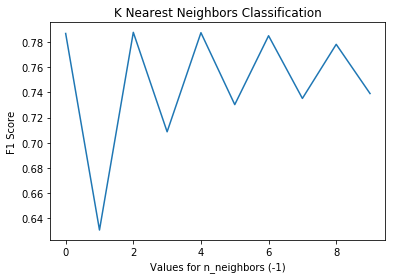

In [13]:
plt.plot(knn_f1_values)
plt.title('K Nearest Neighbors Classification')
plt.xlabel('Values for n_neighbors (-1)')
plt.ylabel('F1 Score')

In [14]:
neigh = KNeighborsClassifier(n_neighbors = 400)
neigh.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=400, p=2,
           weights='uniform')

In [15]:
y_pred = neigh.predict(X_test)
print(f1_score(y_pred, y_test, average = 'weighted'))

0.971437050226278


C:\Users\pishi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [16]:
knn_f1_values_2 = []

k = 300
for i in range(30, 40):
    k += 10
    
    neigh = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    f1 = f1_score(y_pred, y_test, average = 'weighted')
    knn_f1_values_2.append(f1)
    print('F1 score for k = ', k , 'is:', f1)

F1 score for k =  310 is: 0.9654740145561825
F1 score for k =  320 is: 0.9661449762718728
F1 score for k =  330 is: 0.9664841724092081
F1 score for k =  340 is: 0.9685988617054654
F1 score for k =  350 is: 0.970630832863404
F1 score for k =  360 is: 0.9708429354742006
F1 score for k =  370 is: 0.9711540275982751
F1 score for k =  380 is: 0.9712206089605793


C:\Users\pishi\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


F1 score for k =  390 is: 0.971437050226278
F1 score for k =  400 is: 0.971437050226278


Text(0,0.5,'F1 Score')

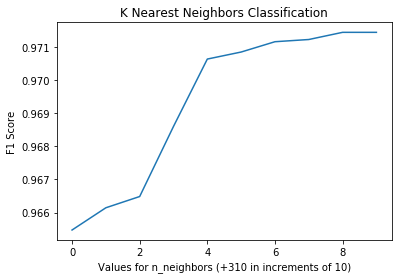

In [17]:
plt.plot(knn_f1_values_2)
plt.title('K Nearest Neighbors Classification')
plt.xlabel('Values for n_neighbors (+310 in increments of 10)')
plt.ylabel('F1 Score')

Text(0.5,1,'Comparison of Different Classification Algorithms on F1')

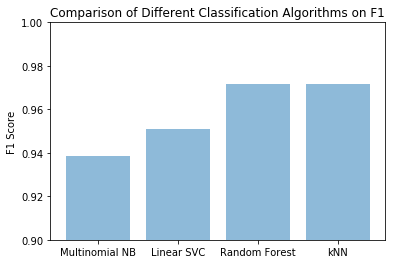

In [18]:
objects = ('Multinomial NB', 'Linear SVC', 'Random Forest', 'kNN')
y_pos = np.arange(len(objects))
performance = [MNB_f1, LSVC_f1, RFC_f1, knn_f1_values_2[-1]]

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylim(0.9, 1.0)
plt.ylabel('F1 Score')
plt.title('Comparison of Different Classification Algorithms on F1')

In [19]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline

RSME_values = []
for k in range(10):
    k += 1
    
    reg = KNeighborsRegressor(n_neighbors = k)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    err = sqrt(mean_squared_error(y_pred, y_test))
    RSME_values.append(err)
    print('RSME value for k = ', k , 'is:', err)

RSME value for k =  1 is: 0.41968993583226666
RSME value for k =  2 is: 0.37392855204057346
RSME value for k =  3 is: 0.3653370777175464
RSME value for k =  4 is: 0.36056062889486346
RSME value for k =  5 is: 0.3558917993989183
RSME value for k =  6 is: 0.35313378288654207
RSME value for k =  7 is: 0.3520743299814108
RSME value for k =  8 is: 0.3514913152430466
RSME value for k =  9 is: 0.35040488543628123
RSME value for k =  10 is: 0.35019984402611404


In [20]:
kNN_rsme = np.mean(RSME_values)
print(kNN_rsme)

0.36327121514575633


Text(0,0.5,'RSME Value')

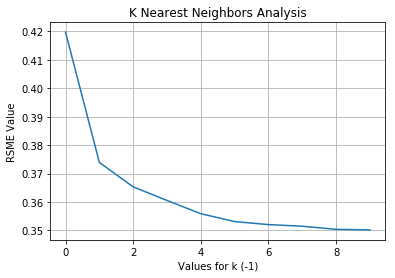

In [21]:
plt.plot(RSME_values)
plt.grid()
plt.title("K Nearest Neighbors Analysis")
plt.xlabel('Values for k (-1)')
plt.ylabel('RSME Value')

In [22]:
reg1 = KNeighborsRegressor(n_neighbors = 400)
reg1.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=400, p=2,
          weights='uniform')

In [23]:
y_pred_knn_reg = reg1.predict(X_test)
kNN_reg_rsme = sqrt(mean_squared_error(y_pred_knn_reg, y_test))
print(kNN_reg_rsme)

0.28712807737804275


In [24]:
from sklearn import linear_model
reg2 = linear_model.BayesianRidge()
reg2.fit(X_train.toarray(), y_train)

BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, compute_score=False, copy_X=True,
       fit_intercept=True, lambda_1=1e-06, lambda_2=1e-06, n_iter=300,
       normalize=False, tol=0.001, verbose=False)

In [30]:
y_pred_bayesian = reg2.predict(X_test)
bayesian_rsme = sqrt(mean_squared_error(y_pred, y_test))
print(bayesian_rsme)

0.21243161793107346


Text(0.5,1,'Weights of Model')

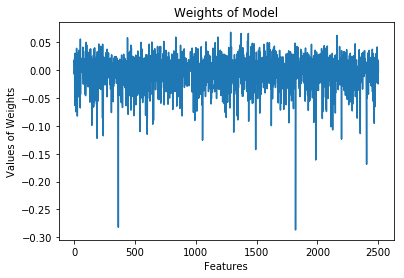

In [31]:
plt.plot(reg2.coef_)
plt.xlabel('Features')
plt.ylabel('Values of Weights')
plt.title('Weights of Model')

In [32]:
from sklearn.linear_model import Ridge
reg3 = Ridge(alpha = 1.0)
reg3.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [33]:
y_pred = reg3.predict(X_test)
ridge_rsme = sqrt(mean_squared_error(y_pred, y_test))
print(ridge_rsme)

0.21242581351088677


Text(0.5,1,'Comparison of Different Regression Algorithms on RSME')

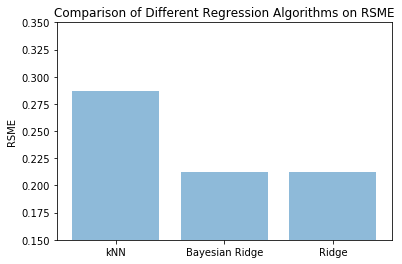

In [34]:
objects = ('kNN', 'Bayesian Ridge', 'Ridge')
y_pos = np.arange(len(objects))
performance = [kNN_reg_rsme, bayesian_rsme, ridge_rsme]

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylim(0.15, 0.35)
plt.ylabel('RSME')
plt.title('Comparison of Different Regression Algorithms on RSME')